In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
import joblib

<h2>Load Cleaned Movies Dataset</h2>

In [2]:
df = pd.read_pickle("../datasets/clean/movies_df.pkl")  

In [3]:
df.shape

(31516, 28)

In [4]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,director,producer,text_corpus
0,False,Toy Story Collection,30000000,"Animation, Comedy, Family",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"Bonnie Arnold, Ralph Guggenheim","Toy Story, Animation, Comedy, Family, Tom Hank..."
1,False,None,65000000,"Adventure, Fantasy, Family",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,"Scott Kroopf, William Teitler","Jumanji, Adventure, Fantasy, Family, Robin Wil..."
2,False,Grumpy Old Men Collection,0,"Romance, Comedy",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",Howard Deutch,,"Grumpier Old Men, Romance, Comedy, Walter Matt..."
3,False,None,16000000,"Comedy, Drama, Romance",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...","Waiting to Exhale, Comedy, Drama, Romance, Whi..."
4,False,Father of the Bride Collection,0,Comedy,NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,Nancy Meyers,"Father of the Bride Part II, Comedy, Steve Mar..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45531,False,None,0,Science Fiction,NaN,222848,tt0112613,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,...,Released,NaN,Caged Heat 3000,False,3.5,1.0,"Lisa Boyle, Kena Land, Zaneta Polard, Don Yana...",Aaron Osborne,Mike Upton,"Caged Heat 3000, Science Fiction, Lisa Boyle, ..."
45532,False,None,0,"Drama, Action, Romance",NaN,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",...,Released,NaN,Robin Hood,False,5.7,26.0,"Patrick Bergin, Uma Thurman, David Morrissey, ...",John Irvin,Sarah Radclyffe,"Robin Hood, Drama, Action, Romance, Patrick Be..."
45535,False,None,0,"Action, Drama, Thriller",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,Released,A deadly game of wits.,Betrayal,False,3.8,6.0,"Erika Eleniak, Adam Baldwin, Julie du Page, Ja...",Mark L. Lester,,"Betrayal, Action, Drama, Thriller, Erika Eleni..."
45536,False,None,0,,NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,Released,NaN,Satan Triumphant,False,0.0,0.0,"Iwan Mosschuchin, Nathalie Lissenko, Pavel Pav...",Yakov Protazanov,Joseph N. Ermolieff,"Satan Triumphant, , Iwan Mosschuchin, Nathalie..."


<h2>Feature Extraction for Movie Recommender</h2>

In [5]:
sample_df = df[['id', 'title', 'genres', 'overview', 'cast', 'director', 'producer']]
sample_df.shape

(31516, 7)

<h2>Saving and Loading Sample Movies Dataset</h2>

In [6]:
sample_df.to_pickle("../datasets/clean/sample_movies_df.pkl") 

In [7]:
sample_df = pd.read_pickle("../datasets/clean/sample_movies_df.pkl")
sample_df.shape  

(31516, 7)

In [8]:
sample_df.head()

,id,title,genres,overview,cast,director,producer
0,862,Toy Story,"Animation, Comedy, Family","Led by Woody, Andy's toys live happily in his ...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"Bonnie Arnold, Ralph Guggenheim"
1,8844,Jumanji,"Adventure, Fantasy, Family",When siblings Judy and Peter discover an encha...,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,"Scott Kroopf, William Teitler"
2,15602,Grumpier Old Men,"Romance, Comedy",A family wedding reignites the ancient feud be...,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",Howard Deutch,
3,31357,Waiting to Exhale,"Comedy, Drama, Romance","Cheated on, mistreated and stepped on, the wom...","Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,..."
4,11862,Father of the Bride Part II,Comedy,Just when George Banks has recovered from his ...,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,Nancy Meyers


<h2>Saving and Loading Sample 10000 Movies Dataset For Testing Purpose</h2>

In [9]:
sample_size=10000
toy_story_movies = sample_df[sample_df['title'].str.contains('Toy Story', case=False)]
remaining_sample_size = sample_size - len(toy_story_movies)

if remaining_sample_size > 0:
    non_toy_story_movies = sample_df[~sample_df['title'].str.contains('Toy Story', case=False)]
    sampled_non_toy_story = non_toy_story_movies.sample(n=min(remaining_sample_size, len(non_toy_story_movies)))
    sample_10000_df = pd.concat([toy_story_movies, sampled_non_toy_story], ignore_index=True).fillna('')
else:
    sample_10000_df = toy_story_movies.sample(n=sample_size, ignore_index=True).fillna('')

sample_10000_df = sample_10000_df.sample(frac=1).reset_index(drop=True).fillna('')

print(sample_10000_df.shape)
print(sample_10000_df[sample_10000_df['title'].str.contains('Toy Story', case=False)])


(10000, 7)
          id                       title                     genres  \
373    10193                 Toy Story 3  Animation, Family, Comedy   
513      862                   Toy Story  Animation, Comedy, Family   
5107  256835  Toy Story That Time Forgot          Animation, Family   
5286  213121        Toy Story of Terror!  Animation, Comedy, Family   
9587     863                 Toy Story 2  Animation, Comedy, Family   

                                               overview  \
373   Woody, Buzz, and the rest of Andy's toys haven...   
513   Led by Woody, Andy's toys live happily in his ...   
5107  During a post-Christmas play date, the gang fi...   
5286  What starts out as a fun road trip for the Toy...   
9587  Andy heads off to Cowboy Camp, leaving his toy...   

                                                   cast       director  \
373   Tom Hanks, Tim Allen, Ned Beatty, Joan Cusack,...    Lee Unkrich   
513   Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...  Jo

In [10]:
sample_10000_df.head()

,id,title,genres,overview,cast,director,producer
0,84771,Lovelines,Comedy,"Greed, lust, dirty tricks and bloody fist figh...","Greg Bradford, Mary Beth Evans, Michael Winslo...",Rod Amateau,
1,29988,Ishq,"Action, Comedy, Drama, Foreign, Romance",Harbans Rai and Ranjit Rai are two wealthy bus...,"Aamir Khan, Ajay Devgn, Juhi Chawla, Kajol, Da...",Indra Kumar,
2,19236,Santa Sangre,"Fantasy, Horror, Mystery",A young man is confined in a mental hospital. ...,"Axel Jodorowsky, Blanca Guerra, Guy Stockwell,...",Alejandro Jodorowsky,Claudio Argento
3,28353,Def Jam's How to Be a Player,"Comedy, Romance",Dray is a young playboy whose only objective i...,"Bill Bellamy, Lark Voorhies, Bernie Mac, Elise...",Lionel C. Martin,
4,12106,The Quick and the Dead,"Action, Western",A mysterious woman comes to compete in a quick...,"Sharon Stone, Gene Hackman, Russell Crowe, Leo...",Sam Raimi,"Patrick Markey, Allen Shapiro, Joshua Donen"


In [11]:
sample_10000_df.to_pickle("../datasets/clean/sample_10000_movies_df.pkl") 

In [ ]:
sample_10000_df.to_pickle("../sample_10000_for_recommender_model_df.pkl") 

In [12]:
sample_10000_df = pd.read_pickle("../datasets/clean/sample_10000_movies_df.pkl")
sample_10000_df.shape

(10000, 7)

<h2>OOP movie recommendation model Using sample_10000_movies_df Dataframe</h2>

In [56]:
# OOP movie recommendation model
class MovieRecommender:
    """
    A class for generating movie recommendations based on multiple attributes
    using TF-IDF and cosine similarity.
    """

    def __init__(self, data_path="../datasets/clean/sample_10000_movies_df.pkl", similarity_dir="../models/"):
        """
        Initializes the MovieRecommender with the movie data path.
        """
        self.data_path = data_path
        self.df_sample = pd.read_pickle(self.data_path)
        self.similarity_matrices = {}
        self.weights = {}
        self.recommended_movies = None
        self.similarity_dir = similarity_dir


    def calculate_similarity(self, attributes=('title', 'genres', 'overview', 'cast', 'director', 'producer')):
        """
        Calculates cosine similarity matrices for the specified movie attributes.

        Args:
            attributes (tuple, optional): The movie attributes to calculate similarity for.
                Defaults to ('title', 'genres', 'overview', 'cast', 'director', 'producer').
        """
        tfidf = TfidfVectorizer(stop_words='english')
        for attr in attributes:
            tfidf_matrix = tfidf.fit_transform(self.df_sample[attr])
            self.similarity_matrices[attr] = cosine_similarity(tfidf_matrix, tfidf_matrix)
            filename = self.similarity_dir + f"cosine_similarity_{attr}.joblib"
            joblib.dump(self.similarity_matrices[attr], filename)

    def get_recommendations(self, movie_index, num_recommendations=10):
        """
        Generates movie recommendations for a given movie index based on weighted similarity scores.

        Args:
            movie_index (int): The index of the movie to get recommendations for.
            num_recommendations (int, optional): The number of recommendations to return. Defaults to 10.

        Returns:
            pandas.DataFrame: A DataFrame containing the recommended movies, sorted by combined similarity score.
        """
        if not self.weights:
            raise ValueError("Weights must be set before getting recommendations.")
        if not self.similarity_matrices:
            raise ValueError("Similarity matrices must be calculated before getting recommendations.")

        # Calculate weighted similarity scores
        weighted_scores = np.zeros(len(self.df_sample))
        for attr, similarity_matrix in self.similarity_matrices.items():
            weighted_scores += self.weights[attr] * similarity_matrix[movie_index]

        # Get the indices of the top recommendations, excluding the input movie itself
        similar_indices = np.argsort(weighted_scores)[::-1][1:num_recommendations + 1]

        # Return the recommended movies as a DataFrame
        recommended_movies = self.df_sample.iloc[similar_indices].copy() # Ensure no changes to original
        recommended_movies['combined_similarity'] = weighted_scores[similar_indices] #add similarity score
        return recommended_movies

    def set_weights(self, weights):
        """
        Sets the weights for each attribute used in the recommendation process.

        Args:
            weights (dict): A dictionary mapping attribute names to their corresponding weights.
        """
        # Basic input validation
        if not isinstance(weights, dict):
            raise TypeError("Weights must be a dictionary.")
        if set(weights.keys()) != set(self.similarity_matrices.keys()):
            raise ValueError("Weights must be provided for all attributes used in similarity calculation.")
        if not all(isinstance(value, (int, float)) for value in weights.values()):
            raise TypeError("All weights must be numeric.")
        if not np.isclose(sum(weights.values()), 1):
            raise ValueError("Weights must sum to 1.")
        self.weights = weights

    def find_optimal_weights(self, target_movie_index, num_iterations=1000):
        """
        Finds a set of weights that maximizes the average similarity of the top recommendations
        for a given movie, using a randomized approach.

        Args:
            target_movie_index (int): The index of the target movie.
            num_iterations (int, optional): The number of random weight sets to try. Defaults to 1000.

        Returns:
            dict: The optimal set of weights found.
        """
        best_weights = None
        best_avg_similarity = -1  # Initialize with a very low value

        for _ in range(num_iterations):
            # Generate a random set of weights using a Dirichlet distribution
            weights = dict(zip(self.similarity_matrices.keys(), np.random.dirichlet(np.ones(len(self.similarity_matrices)))))

            self.set_weights(weights)  # Set the weights
            recommendations_df = self.get_recommendations(target_movie_index)
            avg_similarity = recommendations_df['combined_similarity'].mean()

            if avg_similarity > best_avg_similarity:
                best_avg_similarity = avg_similarity
                best_weights = weights

        return best_weights

    def recommend_movies(self, movie_title=None, num_recommendations=10):
        """
        Recommends movies based on a given movie title.  It uses the
        find_optimal_weights method to determine the best weights.

        Args:
            movie_title (str): The title of the movie to find recommendations for.
            num_recommendations (int): number of movies to recommend

        Returns:
           pd.DataFrame: A DataFrame containing the recommended movies

        """
        self.calculate_similarity()
        
        if movie_title:
            try:
                target_movie_index = self.df_sample[self.df_sample['title'] == movie_title].index[0]
                print(f"Recommendations for '{movie_title}':")
            except IndexError:
                raise ValueError(f"Movie title '{movie_title}' not found in the dataset.")
        else:
            target_movie_index = self.df_sample.sample(n=1).index.values[0]
            print(f"Recommendations for '{self.df_sample.iloc[target_movie_index].title}':")
        
        optimal_weights = self.find_optimal_weights(target_movie_index)
        print("\n Best Optimal Weights: ")
        print(optimal_weights)
        self.set_weights(optimal_weights)
        print("\n Recommendations: ")
        recommendations = self.get_recommendations(target_movie_index, num_recommendations)
        # print(recommendations)
        return recommendations, optimal_weights

<h2>Testing</h2>

In [14]:
# 1. Instantiate the MovieRecommender
recommender = MovieRecommender()

# 2. Recommend movies
movie_title = "Toy Story" 
try:
    recommendations_df, optimal_weights = recommender.recommend_movies(movie_title)
    print(f"\n Results: ")
    print(recommendations_df[['title', 'combined_similarity']])
except ValueError as e:
    print(f"Error: {e}")

Recommendations for 'Toy Story':

 Best Optimal Weights: 
{'title': 0.2056441731415186, 'genres': 0.6851272832383737, 'overview': 0.00877850142979308, 'cast': 0.05607083478379577, 'director': 0.03789766450073498, 'producer': 0.006481542905783756}

 Results: 
                                           title  combined_similarity
9587                                 Toy Story 2             0.961688
373                                  Toy Story 3             0.915759
5286                        Toy Story of Terror!             0.868093
5107                  Toy Story That Time Forgot             0.789547
1996                           The Christmas Toy             0.772707
9170                              Chicken Little             0.688238
4002                                         Hop             0.687319
7392               Tom and Jerry: The Magic Ring             0.687104
4251                           Rover Dangerfield             0.687065
7647  Kung Fu Panda: Secrets of the Furio

In [24]:
# 1. Instantiate the MovieRecommender
recommender = MovieRecommender()

# 2. Recommend movies
movie_title = "Toy Story" 
try:
    recommendations_df, optimal_weights = recommender.recommend_movies(movie_title)
    print(f"\n Results: ")
    print(recommendations_df[['title', 'combined_similarity']])
except ValueError as e:
    print(f"Error: {e}")

Recommendations for 'Toy Story':

 Best Optimal Weights: 
{'title': 0.048244128946098884, 'genres': 0.6976116673043851, 'overview': 0.05645186786725546, 'cast': 0.1284033076928519, 'director': 0.0449306506093211, 'producer': 0.0243583775800877}

 Results: 
                                           title  combined_similarity
9587                                 Toy Story 2             0.882778
373                                  Toy Story 3             0.821818
5286                        Toy Story of Terror!             0.778031
5107                  Toy Story That Time Forgot             0.722426
9170                              Chicken Little             0.704735
4002                                         Hop             0.702631
7392               Tom and Jerry: The Magic Ring             0.702137
4251                           Rover Dangerfield             0.702048
7647  Kung Fu Panda: Secrets of the Furious Five             0.701938
7987                    An Extremely Goofy 

<h2>Saving and Loading Sample 1000 Movies Dataset For Testing Purpose</h2>

In [25]:
sample_size=1000
toy_story_movies = sample_df[sample_df['title'].str.contains('Toy Story', case=False)]
remaining_sample_size = sample_size - len(toy_story_movies)

if remaining_sample_size > 0:
    non_toy_story_movies = sample_df[~sample_df['title'].str.contains('Toy Story', case=False)]
    sampled_non_toy_story = non_toy_story_movies.sample(n=min(remaining_sample_size, len(non_toy_story_movies)))
    sample_1000_df = pd.concat([toy_story_movies, sampled_non_toy_story], ignore_index=True).fillna('')
else:
    sample_1000_df = toy_story_movies.sample(n=sample_size, ignore_index=True).fillna('')

sample_1000_df = sample_1000_df.sample(frac=1).reset_index(drop=True).fillna('')

print(sample_1000_df.shape)
print(sample_1000_df[sample_1000_df['title'].str.contains('Toy Story', case=False)])


(1000, 7)
         id                       title                     genres  \
171  256835  Toy Story That Time Forgot          Animation, Family   
176   10193                 Toy Story 3  Animation, Family, Comedy   
305     862                   Toy Story  Animation, Comedy, Family   
466     863                 Toy Story 2  Animation, Comedy, Family   
470  213121        Toy Story of Terror!  Animation, Comedy, Family   

                                              overview  \
171  During a post-Christmas play date, the gang fi...   
176  Woody, Buzz, and the rest of Andy's toys haven...   
305  Led by Woody, Andy's toys live happily in his ...   
466  Andy heads off to Cowboy Camp, leaving his toy...   
470  What starts out as a fun road trip for the Toy...   

                                                  cast       director  \
171  Tom Hanks, Tim Allen, Joan Cusack, Kristen Sch...  Steve Purcell   
176  Tom Hanks, Tim Allen, Ned Beatty, Joan Cusack,...    Lee Unkrich   
3

In [26]:
sample_1000_df.to_pickle("../datasets/clean/sample_1000_movies_df.pkl") 
sample_1000_df.to_pickle("../sample_1000_for_recommender_model_df.pkl") 

<h2>Analysis</h2>

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
def run_analysis(movie_title_to_analyze, num_runs=10, num_recommendations=10):
    """
    Runs the optimal weight analysis and movie recommendation process for a given movie
    multiple times and visualizes the optimal weights and movie title distribution.
    """
    recommender = MovieRecommender()

    try:
        target_movie_index = recommender.df_sample[recommender.df_sample['title'] == movie_title_to_analyze].index[0]
        print(f"Analyzing optimal weights for '{movie_title_to_analyze}' over {num_runs} runs.")
    except IndexError:
        print(f"Error: Movie title '{movie_title_to_analyze}' not found in the dataset.")
        return None, None

    all_optimal_weights = []
    all_recommendations_dfs = []
    all_recommended_titles_for_freq_chart = []

    for i in range(num_runs):
        print(f"--- Run {i+1}/{num_runs} for '{movie_title_to_analyze}' ---")
        # Call recommend_movies which now returns optimal_weights as well
        recommendations_df, optimal_weights = recommender.recommend_movies(movie_title=movie_title_to_analyze, num_recommendations=num_recommendations)
        if optimal_weights:
            all_optimal_weights.append(optimal_weights)
        else:
            print(f"Warning: No optimal weights found for run {i+1}.")
        
        if recommendations_df is not None:
            # Add a 'Run' column to the recommendations for tracking
            recommendations_df['Run'] = i + 1
            all_recommendations_dfs.append(recommendations_df)
            all_recommended_titles_for_freq_chart.extend(recommendations_df['title'].tolist())
        # last_recommendations_df = recommendations_df # Keep track of the last recommendations

    if not all_optimal_weights:
        print("No optimal weights were found across all runs. Cannot generate visualization.")
        return None, None
    else:
        weights_df = pd.DataFrame(all_optimal_weights)
        weights_df['Run'] = range(1, len(weights_df) + 1)
        weights_melted = weights_df.melt(id_vars=['Run'], var_name='Attribute', value_name='Weight')

        # Visualization for Optimal Weights
        plt.figure(figsize=(12, 7))
        sns.barplot(data=weights_melted, x='Attribute', y='Weight', hue='Run', palette='viridis')
        plt.title(f'Optimal Weights Distribution for "{movie_title_to_analyze}" Across {num_runs} Runs')
        plt.xlabel('Movie Attribute')
        plt.ylabel('Weight')
        plt.legend(title='Run', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # New Visualization for Movie Title Distribution (aggregated across all runs)
        if all_recommendations_dfs:
            combined_recommendations_df = pd.concat(all_recommendations_dfs, ignore_index=True)
            # Group by title and calculate the mean similarity and count occurrences
            movie_title_summary = combined_recommendations_df.groupby('title')['combined_similarity'].agg(['mean', 'count']).reset_index()
            movie_title_summary.rename(columns={'mean': 'average_similarity', 'count': 'recommendation_count'}, inplace=True)
            
            # Sort by average similarity for better visualization
            movie_title_summary_sorted = movie_title_summary.sort_values(by='average_similarity', ascending=False)

            plt.figure(figsize=(14, 8))
            sns.barplot(data=movie_title_summary_sorted, x='title', y='average_similarity', palette='coolwarm')
            plt.title(f'Average Combined Similarity of Recommended Movie Titles for "{movie_title_to_analyze}" Across {num_runs} Runs')
            plt.xlabel('Recommended Movie Title')
            plt.ylabel('Average Combined Similarity Score')
            plt.xticks(rotation=45, ha='right') # Rotate labels for readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
            print(f"\nAggregated Movie Title Distribution Across {num_runs} Runs:")
            print(movie_title_summary_sorted)

        
        if all_recommended_titles_for_freq_chart:
            recommended_titles_series = pd.Series(all_recommended_titles_for_freq_chart)
            top_frequent_recommended = recommended_titles_series.value_counts().head(num_recommendations)

            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_frequent_recommended.values, y=top_frequent_recommended.index, palette='viridis')
            plt.title(f"Top {num_recommendations} Most Frequently Recommended Movies for '{movie_title_to_analyze}' over {num_runs} runs.")
            plt.xlabel('Number of Times Recommended')
            plt.ylabel('Movie Title')
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()


        print(f"\nAnalysis complete for '{movie_title_to_analyze}'.")
        print(f"Optimal weights found across {num_runs} runs:")
        print(weights_df)

        return weights_df, last_recommendations_df

Analyzing optimal weights for 'Toy Story' over 5 runs.
--- Run 1/5 for 'Toy Story' ---
Recommendations for 'Toy Story':

 Best Optimal Weights: 
{'title': 0.09788145243791442, 'genres': 0.7695748177768948, 'overview': 0.002128239926202609, 'cast': 0.11930433713702553, 'director': 0.0016985459942276215, 'producer': 0.009412606727735105}

 Recommendations: 
--- Run 2/5 for 'Toy Story' ---
Recommendations for 'Toy Story':

 Best Optimal Weights: 
{'title': 0.05251827336490767, 'genres': 0.8524246418076612, 'overview': 0.03517519028994, 'cast': 0.018246987047599226, 'director': 0.03136227737689694, 'producer': 0.010272630112995037}

 Recommendations: 
--- Run 3/5 for 'Toy Story' ---
Recommendations for 'Toy Story':

 Best Optimal Weights: 
{'title': 0.005492987224959974, 'genres': 0.7829047476162113, 'overview': 0.18516151220147006, 'cast': 0.004680322507493967, 'director': 0.009058329126300734, 'producer': 0.01270210132356397}

 Recommendations: 
--- Run 4/5 for 'Toy Story' ---
Recommenda

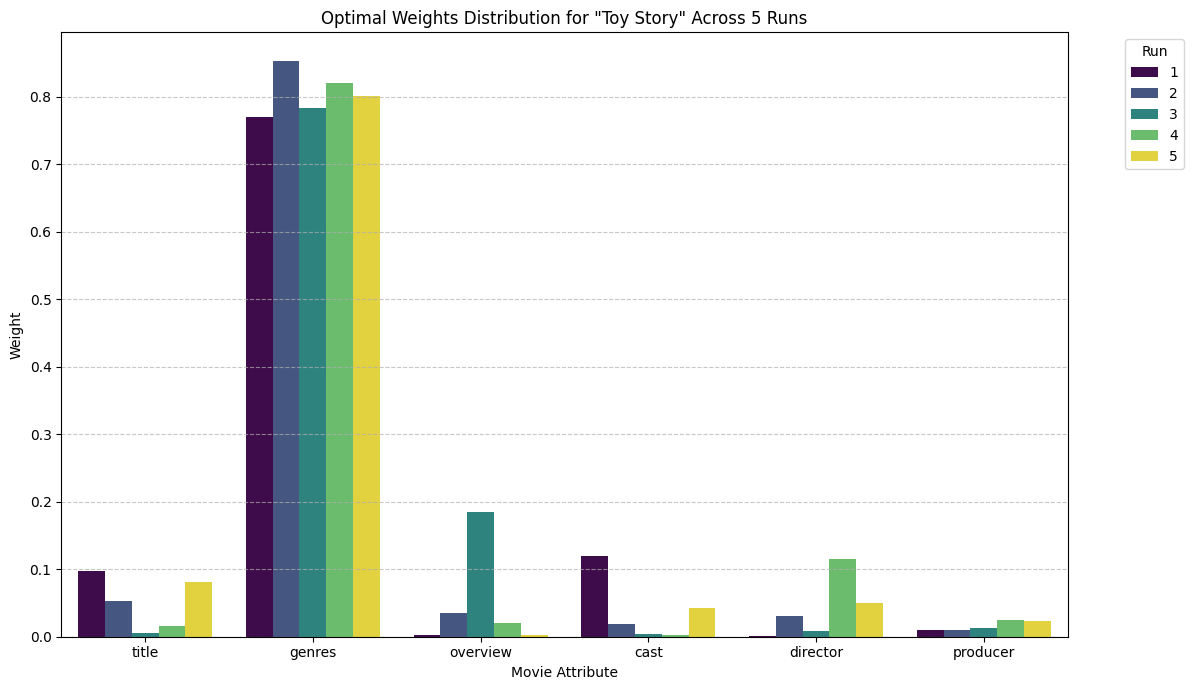

/var/folders/7q/qzjprl350c502h29h0xphq9m0000gn/T/ipykernel_25109/3591114666.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=movie_title_summary_sorted, x='title', y='average_similarity', palette='coolwarm')


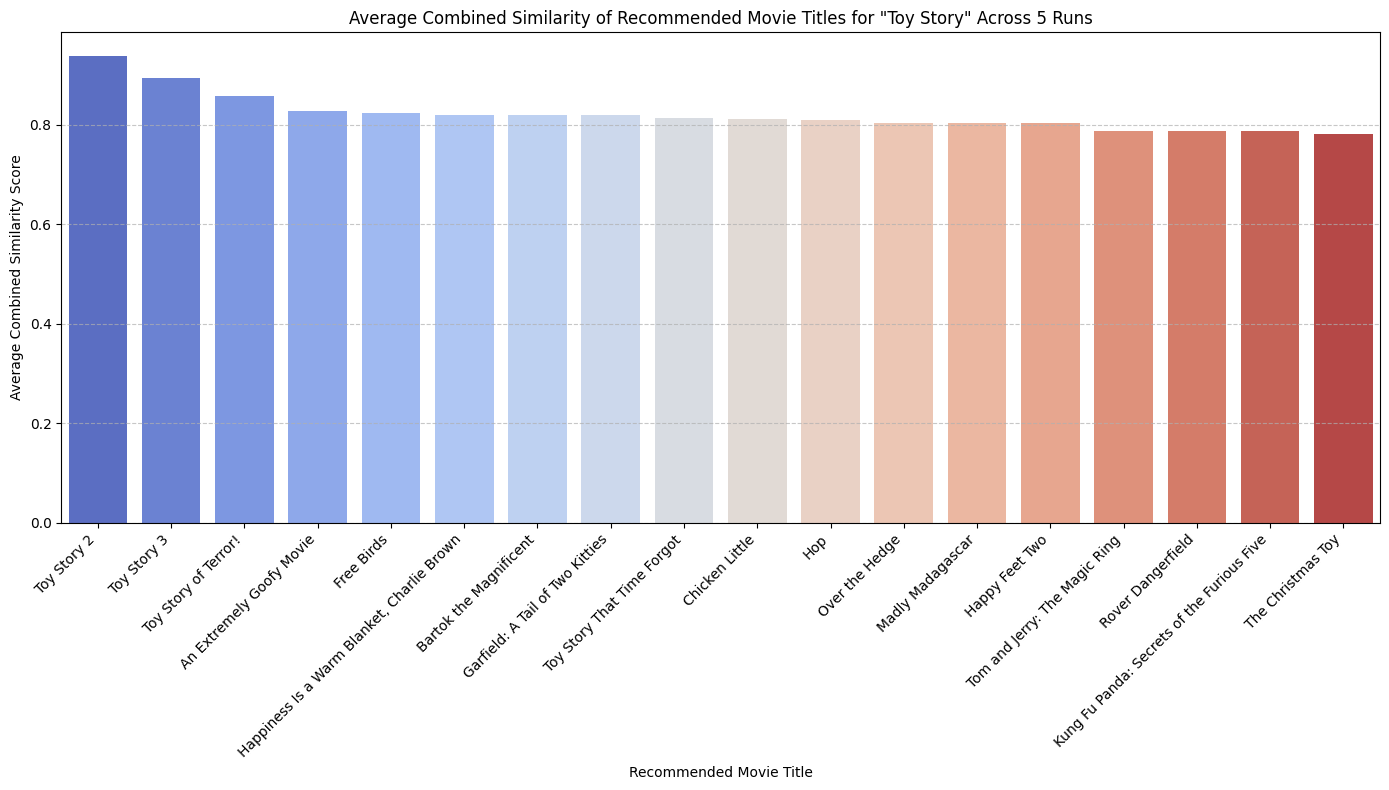


Aggregated Movie Title Distribution Across 5 Runs:
                                         title  average_similarity  \
14                                 Toy Story 2            0.938961   
15                                 Toy Story 3            0.894762   
17                        Toy Story of Terror!            0.858894   
0                     An Extremely Goofy Movie            0.827272   
3                                   Free Birds            0.823350   
5   Happiness Is a Warm Blanket, Charlie Brown            0.820340   
1                       Bartok the Magnificent            0.820087   
4              Garfield: A Tail of Two Kitties            0.819877   
16                  Toy Story That Time Forgot            0.814198   
2                               Chicken Little            0.810802   
7                                          Hop            0.809816   
10                              Over the Hedge            0.803438   
9                             Madly Ma

/var/folders/7q/qzjprl350c502h29h0xphq9m0000gn/T/ipykernel_25109/3591114666.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_frequent_recommended.values, y=top_frequent_recommended.index, palette='viridis')


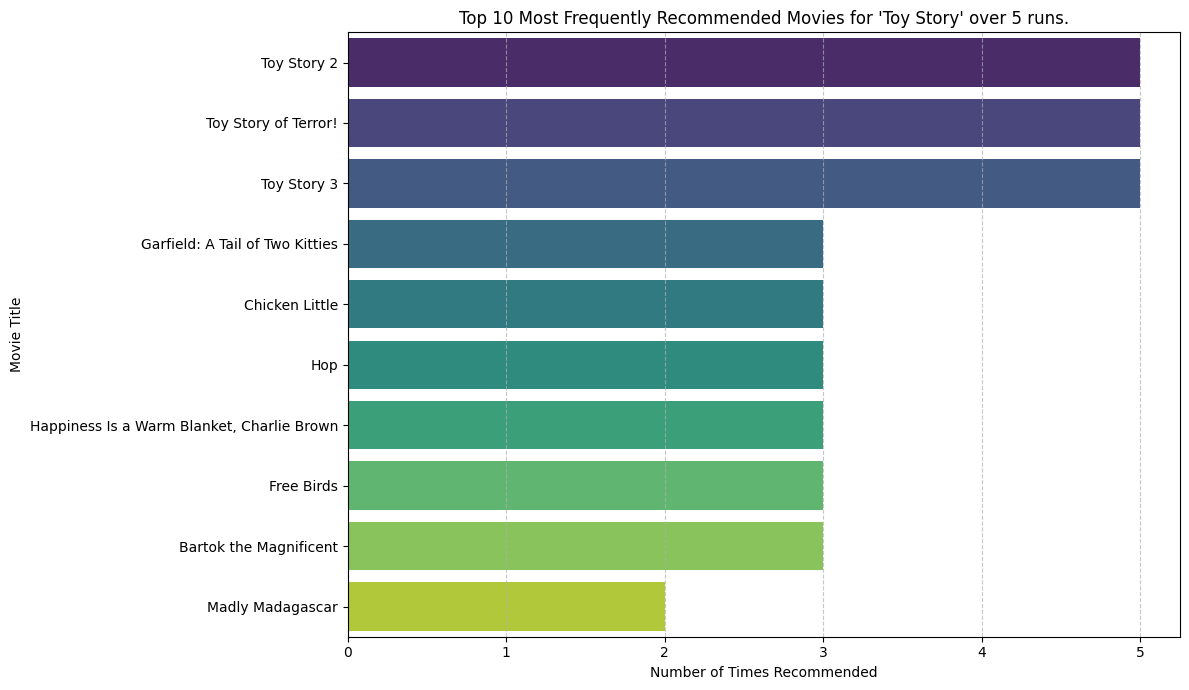


Analysis complete for 'Toy Story'.
Optimal weights found across 5 runs:
      title    genres  overview      cast  director  producer  Run
0  0.097881  0.769575  0.002128  0.119304  0.001699  0.009413    1
1  0.052518  0.852425  0.035175  0.018247  0.031362  0.010273    2
2  0.005493  0.782905  0.185162  0.004680  0.009058  0.012702    3
3  0.016301  0.820524  0.021058  0.002519  0.115481  0.024118    4
4  0.080351  0.800393  0.002679  0.042977  0.050602  0.022998    5


NameError: name 'last_recommendations_df' is not defined

In [67]:
# Set the movie title you want to analyze
movie_to_analyze = "Toy Story"
# Set the number of times to run the optimal weight search (n)
number_of_runs = 5
# Set the number of recommendations to retrieve for each run
number_of_recommendations = 10

# Run the analysis and get the results
optimal_weights_df, final_recommendations = run_analysis(
    movie_to_analyze,
    num_runs=number_of_runs,
    num_recommendations=number_of_recommendations
)